## LAB ACTIVITY 10
## NAME : SONALI R; REG NO : 22MID0061; COURSE CODE: CSI3007; LAB : L7+L8+L27+L28;
## DATE : 26/08/2025

# Forgetting Cursive Writing – A Google Ngram Based Analysis

## Task : Fetch Google Books Ngram JSON, save as CSV, plot, generate word cloud and prepare a prompt for an LLM to produce a human summary.

In [10]:
# Install necessary packages
!pip install requests


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
!pip install wordcloud


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# import necessary packages
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json
import sys

In [23]:
# List of search terms (trends to analyze in Google Books Ngram Viewer)
TERMS = ["cursive", "penmanship", "handwriting"]   # Example: missing trends in millennials/Gen Z lifestyles

# Start year of analysis (earliest year to include in results)
YEAR_START = 1800

# End year of analysis (latest year to include in results)
YEAR_END = 2025

# Google Books Ngram corpus ID (15 = English, modern standard corpus)
# Other IDs correspond to different languages/corpora (check Ngram Viewer UI for details)
CORPUS = 15    

# Smoothing factor (0 = no smoothing, higher numbers smooth out yearly fluctuations)
SMOOTHING = 0

# HTTP User-Agent header (used to mimic a browser request when fetching data)
USER_AGENT = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100 Safari/537.36"

# Filepath for saving extracted Ngram data in CSV format
OUTPUT_CSV = "ngrams_output.csv"

# Filepath for saving the generated trend plot as a PNG image
PLOT_PNG = "ngrams_plot.png"

# Filepath for saving the generated word cloud of terms as a PNG image
WORDCLOUD_PNG = "ngrams_wordcloud.png"


In [27]:
def fetch_ngram_json(terms, year_start=YEAR_START, year_end=YEAR_END, corpus=CORPUS, smoothing=SMOOTHING):
    """
    Uses the Google Ngram JSON endpoint:
    https://books.google.com/ngrams/json?content=...&year_start=...&year_end=...&corpus=...&smoothing=...
    Returns parsed JSON (list of dicts) on success, raises on failure.
    """
    url = "https://books.google.com/ngrams/json?content=cursive,penmanship,handwriting&year_start=1800&year_end=2025&corpus=15&smoothing=0"
    params = {
        "content": ",".join(terms),
        "year_start": year_start,
        "year_end": year_end,
        "corpus": corpus,
        "smoothing": smoothing,
    }
    headers = {"User-Agent": USER_AGENT}
    r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    # The endpoint returns JSON that pandas.read_json can also parse; here we return Python list/dict
    return r.json()

In [29]:
def json_to_dataframe(ngram_json, year_start=YEAR_START, year_end=YEAR_END):
    """
    Convert the JSON returned by the endpoint into a tidy pandas DataFrame:
    columns = ['year', 'ngram', 'freq']
    """
    years = list(range(year_start, year_end + 1))
    rows = []
    for series in ngram_json:
        ngram = series.get("ngram")
        timeseries = series.get("timeseries", [])
        if len(timeseries) != len(years):
            # fill/truncate defensively
            timeseries = (timeseries + [0] * len(years))[:len(years)]
        for y, v in zip(years, timeseries):
            rows.append({"year": y, "ngram": ngram, "freq": float(v)})
    df = pd.DataFrame(rows)
    return df

In [31]:
def pivot_timeseries(df):
    """Return a wide DataFrame indexed by year with each ngram as a column (frequencies)."""
    pivot = df.pivot(index="year", columns="ngram", values="freq").fillna(0)
    return pivot

In [33]:
def save_csv(pivot_df, filename=OUTPUT_CSV):
    """
    Save the given pivoted DataFrame (trend data) to a CSV file.
    Parameters:
    pivot_df : pandas.DataFrame
        The pivoted DataFrame containing Google Ngram data.
        Typically, rows = years and columns = search terms.
    """
    
    # Save DataFrame as CSV (include index = years)
    pivot_df.to_csv(filename, index=True)

    # Print confirmation for user
    print(f"[+] Saved CSV to {filename}")


In [35]:
def plot_timeseries(pivot_df, filename=PLOT_PNG):
    plt.figure(figsize=(12,6))
    ax = plt.gca()
    pivot_df.plot(ax=ax, linewidth=2)
    ax.set_xlabel("Year")
    ax.set_ylabel("Relative frequency (%)")
    ax.set_title("Google Books Ngram time series")
    ax.grid(axis="y", alpha=0.3)
    plt.legend(title="ngram", loc="upper right")
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.close()
    print(f"[+] Saved time-series plot to {filename}")

In [37]:
def generate_wordcloud(pivot_df, filename=WORDCLOUD_PNG):
    """
    Create a simple word cloud where word sizes are proportional to the overall mean frequency
    across years for each ngram.
    """
    means = pivot_df.mean(axis=0).to_dict()
    # WordCloud expects a text or a frequency dict; we feed frequency dict
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(means)
    wc.to_file(filename)
    print(f"[+] Saved word cloud to {filename}")

In [39]:
def compute_summary_stats(pivot_df):
    """Return a dict of helpful summary statistics for each ngram."""
    stats = {}
    for col in pivot_df.columns:
        series = pivot_df[col]
        stats[col] = {
            "mean": float(np.mean(series)),
            "median": float(np.median(series)),
            "std": float(np.std(series, ddof=0)),
            "max_value": float(series.max()),
            "max_year": int(series.idxmax()),
            "min_year": int(series.idxmin())
        }
    return stats

In [41]:
def prepare_llm_prompt(summary_stats, pivot_df, top_n_years=5):
    """
    Prepare a textual prompt to send to an LLM along with the CSV or summary.
    The prompt asks the LLM for an interpretive summary and recommended
    human-readable labels for the produced word cloud.
    """
    short_table = pivot_df.mean(axis=0).sort_values(ascending=False).head(top_n_years).to_dict()
    prompt = {
        "instruction": "You are given frequency time-series data (Google Ngram) for several terms. "
                       "Please produce a concise (3-6 sentence) summary about the trends, "
                       "mentioning which term rose or fell and notable years, and suggest 10 short keywords "
                       "suitable for a word cloud. Use the summary statistics and CSV data below.",
        "summary_stats": summary_stats,
        "top_mean_terms": short_table,
        "note": "CSV file attached separately (ngrams_output.csv). Provide the textual summary and a 10-word list for the cloud."
    }
    return json.dumps(prompt, indent=2)


In [49]:
# Inform the user which terms are being fetched
print("[*] Fetching Ngram JSON for:", TERMS)

try:
    # Attempt to fetch JSON data from Google Ngram Viewer
    ngram_json = fetch_ngram_json(TERMS)

    # (Optional) confirm successful fetch
    print(f"[+] Successfully fetched Ngram data for {len(TERMS)} terms.")

except Exception as e:
    # Handle any errors (network issues, invalid response, etc.)
    print("[!] Error fetching Ngram JSON:", e)

    # Exit the script safely with error code 1
    sys.exit(1)


[*] Fetching Ngram JSON for: ['cursive', 'penmanship', 'handwriting']
[+] Successfully fetched Ngram data for 3 terms.


In [51]:
# Convert the fetched Ngram JSON into a long-format DataFrame 
# (columns: year, term, frequency) for easier analysis/plotting
df_long = json_to_dataframe(ngram_json)

In [53]:
# Pivot the long DataFrame into wide format (rows = years, columns = terms, values = frequencies)
pivot_df = pivot_timeseries(df_long)

In [55]:
# Save the pivoted DataFrame to a CSV file for later use
save_csv(pivot_df)

[+] Saved CSV to ngrams_output.csv


In [57]:
# Generate and display a time series plot of term frequencies from the pivoted DataFrame
plot_timeseries(pivot_df)

[+] Saved time-series plot to ngrams_plot.png


In [59]:
# Generate and save a word cloud image from the pivoted DataFrame
generate_wordcloud(pivot_df)

[+] Saved word cloud to ngrams_wordcloud.png


In [61]:
# Compute summary statistics (e.g., mean, max, trends) for each term
stats = compute_summary_stats(pivot_df)

In [63]:
# Print per-term summary statistics in a readable JSON format
print("\n[Summary statistics (per-term)]:")
print(json.dumps(stats, indent=2))


[Summary statistics (per-term)]:
{
  "cursive": {
    "mean": 2.643547123937414e-07,
    "median": 2.1630468438615935e-07,
    "std": 2.322693166755568e-07,
    "max_value": 1.4496442872768966e-06,
    "max_year": 1912,
    "min_year": 1802
  },
  "handwriting": {
    "mean": 3.752254315510571e-06,
    "median": 4.140479859415791e-06,
    "std": 1.8684784324154998e-06,
    "max_value": 8.120618986140471e-06,
    "max_year": 1924,
    "min_year": 2009
  },
  "penmanship": {
    "mean": 4.4027313086529734e-07,
    "median": 3.8897559306860785e-07,
    "std": 2.760173390825902e-07,
    "max_value": 1.460775820305571e-06,
    "max_year": 1925,
    "min_year": 2009
  }
}


In [65]:
# Prepare an LLM-friendly JSON prompt based on stats and data
prompt = prepare_llm_prompt(stats, pivot_df)

In [67]:
# Print the generated LLM prompt for use in downstream tasks
print("\n[LLM prompt you can send (JSON):]\n")
print(prompt)


[LLM prompt you can send (JSON):]

{
  "instruction": "You are given frequency time-series data (Google Ngram) for several terms. Please produce a concise (3-6 sentence) summary about the trends, mentioning which term rose or fell and notable years, and suggest 10 short keywords suitable for a word cloud. Use the summary statistics and CSV data below.",
  "summary_stats": {
    "cursive": {
      "mean": 2.643547123937414e-07,
      "median": 2.1630468438615935e-07,
      "std": 2.322693166755568e-07,
      "max_value": 1.4496442872768966e-06,
      "max_year": 1912,
      "min_year": 1802
    },
    "handwriting": {
      "mean": 3.752254315510571e-06,
      "median": 4.140479859415791e-06,
      "std": 1.8684784324154998e-06,
      "max_value": 8.120618986140471e-06,
      "max_year": 1924,
      "min_year": 2009
    },
    "penmanship": {
      "mean": 4.4027313086529734e-07,
      "median": 3.8897559306860785e-07,
      "std": 2.760173390825902e-07,
      "max_value": 1.4607758203

In [69]:
# Final confirmation with names of all saved output files
print("\n[Done] Files: ", OUTPUT_CSV, PLOT_PNG, WORDCLOUD_PNG)


[Done] Files:  ngrams_output.csv ngrams_plot.png ngrams_wordcloud.png


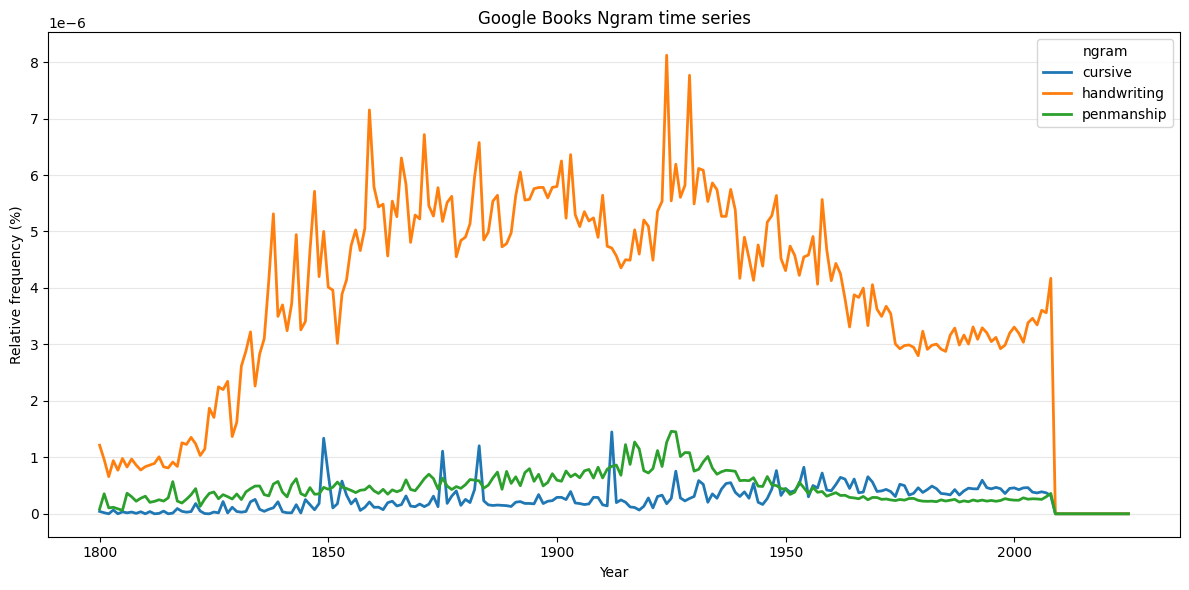

In [135]:
# Visualization of time series plot of term frequencies from the pivoted DataFrame
plt.figure(figsize=(12,6))
ax = plt.gca()
pivot_df.plot(ax=ax, linewidth=2)
ax.set_xlabel("Year")
ax.set_ylabel("Relative frequency (%)")
ax.set_title("Google Books Ngram time series")
ax.grid(axis="y", alpha=0.3)
plt.legend(title="ngram", loc="upper right")
plt.tight_layout()

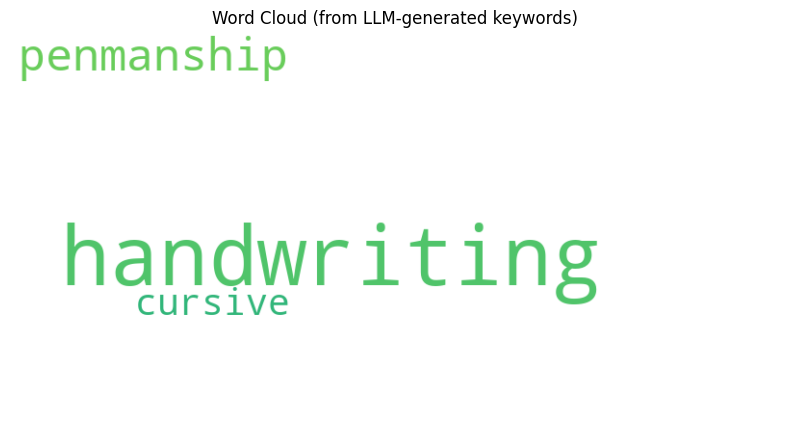

In [139]:
# word cloud from the pivoted DataFrame
means = pivot_df.mean(axis=0).to_dict()
# WordCloud expects a text or a frequency dict; we feed frequency dict
wc = WordCloud(width=800, height=400, background_color="white")
wc.generate_from_frequencies(means)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (from LLM-generated keywords)")
plt.show()

In [71]:
# Load CSV dataset
df = pd.read_csv("ngrams_output.csv")  
# Expecting columns like: ["year", "cursive", "handwriting", "penmanship"]

In [141]:
# display the dataset
print(df)

     year       cursive   handwriting    penmanship
0    1800  4.238222e-08  1.214957e-06  8.476443e-08
1    1801  1.864104e-08  9.600137e-07  3.541798e-07
2    1802  0.000000e+00  6.580872e-07  1.044583e-07
3    1803  6.719577e-08  9.407408e-07  1.151927e-07
4    1804  0.000000e+00  7.715785e-07  8.767937e-08
..    ...           ...           ...           ...
221  2021  0.000000e+00  0.000000e+00  0.000000e+00
222  2022  0.000000e+00  0.000000e+00  0.000000e+00
223  2023  0.000000e+00  0.000000e+00  0.000000e+00
224  2024  0.000000e+00  0.000000e+00  0.000000e+00
225  2025  0.000000e+00  0.000000e+00  0.000000e+00

[226 rows x 4 columns]


In [73]:
# Compute summary statistics
summary_stats = {}
for col in df.columns[1:]:  # skip 'year'
    values = df[col].dropna()
    summary_stats[col] = {
        "mean": float(np.mean(values)),
        "median": float(np.median(values)),
        "std": float(np.std(values)),
        "max_value": float(np.max(values)),
        "max_year": int(df.loc[values.idxmax(), "year"]),
        "min_year": int(df.loc[values.idxmin(), "year"])
    }

In [75]:
# Rank terms by mean frequency
top_mean_terms = {col: summary_stats[col]["mean"] for col in df.columns[1:]}
top_mean_terms = dict(sorted(top_mean_terms.items(), key=lambda x: x[1], reverse=True))

In [77]:
# Prepare JSON prompt for LLM

prompt_payload = {
    "instruction": (
        "You are given frequency time-series data (Google Ngram) for several terms. "
        "Please produce a concise (3-6 sentence) summary about the trends, mentioning "
        "which term rose or fell and notable years, and suggest 10 short keywords "
        "suitable for a word cloud. Use the summary statistics and CSV data below."
    ),
    "summary_stats": summary_stats,
    "top_mean_terms": top_mean_terms,
    "note": "CSV file attached separately (ngrams_output.csv). Provide the textual summary and a 10-word list for the cloud."
}

In [87]:
# Call LLM API

API_KEY = "api-key"   # 🔑 Replace with your API key
API_URL = "https://openrouter.ai/api/v1/chat/completions"  # Example for OpenAI GPT

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {API_KEY}"
}

In [89]:
data = {
    "model": "gpt-4o-mini",  # you can change model if needed
    "messages": [
        {"role": "system", "content": "You are a data analysis assistant."},
        {"role": "user", "content": json.dumps(prompt_payload)}
    ],
    "temperature": 0.3
}

In [91]:
# getting summary response from LLM
response = requests.post(API_URL, headers=headers, json=data)

In [92]:
if response.status_code == 200:
    result = response.json()
    summary = result["choices"][0]["message"]["content"]
    print("\n=== LLM Generated Summary & Keywords ===\n")
    print(summary)
else:
    print("Error:", response.status_code, response.text)


=== LLM Generated Summary & Keywords ===

The analysis of the frequency time-series data reveals that "handwriting" has consistently been the most prominent term, peaking in 1924. In contrast, "cursive" and "penmanship" have shown lower overall frequencies, with "cursive" reaching its maximum in 1912 and "penmanship" peaking in 1925. Notably, both "cursive" and "penmanship" have seen a decline in usage since their peak years, while "handwriting" has maintained a more stable presence, particularly in recent years. The data suggests a shift in focus away from traditional writing styles towards more modern forms of communication.

**Keywords for Word Cloud:**
1. Handwriting
2. Cursive
3. Penmanship
4. Trends
5. Peaks
6. Decline
7. Communication
8. 1924
9. 1912
10. 1925


In [117]:
def extract_keywords(summary_text):
    # 1) Try to grab numbered list items (most reliable)
    numbered = re.findall(r'^\s*\d+\.\s*(.+?)\s*$', summary_text, flags=re.MULTILINE)
    if numbered:
        return numbered

    # 2) Try to find a "Keywords" header and then comma-separated tokens
    m = re.search(r'(?i)keywords(?:\s*for\s*word\s*cloud)?\s*[:\-]\s*(.+)', summary_text, flags=re.S)
    if m:
        tail = m.group(1).strip()
        # if comma separated on same line
        if ',' in tail:
            parts = [p.strip() for p in tail.split(',') if p.strip()]
            if parts:
                return parts
        # otherwise split on newlines and pick tokens
        lines = [ln.strip() for ln in tail.splitlines() if ln.strip()]
        parts = []
        for ln in lines:
            # if starts with number
            if re.match(r'^\d+\.', ln):
                parts.append(re.sub(r'^\d+\.\s*', '', ln).strip())
            else:
                # try splitting by spaces/commas
                parts.extend([p.strip() for p in re.split(r'[,;]\s*|\s{2,}', ln) if p.strip()])
        if parts:
            return parts

    # 3) Fallback: extract quoted words (e.g., "cursive")
    quoted = re.findall(r'"([^"]+)"', summary_text)
    if quoted:
        return quoted

    return []

In [119]:
def clean_keyword(k):
    # remove surrounding quotes and leading/trailing punctuation
    k = k.strip().strip('\'"')
    # strip any leading/trailing punctuation except keep digits (years)
    k = re.sub(r'^[^\w\d]+|[^\w\d]+$', '', k)
    return k

In [121]:
# Extract + clean
raw_keywords = extract_keywords(summary)
cleaned = [clean_keyword(k) for k in raw_keywords if clean_keyword(k)]
# preserve order and remove duplicates (case-insensitive)
seen = set()
keywords = []
for k in cleaned:
    key = k.lower()
    if key not in seen:
        seen.add(key)
        keywords.append(k)

print("Extracted keywords:", keywords)

Extracted keywords: ['Handwriting', 'Cursive', 'Penmanship', 'Trends', 'Peaks', 'Decline', 'Communication', '1924', '1912', '1925']


In [127]:
# Build a simple weighted frequency dict (higher weight for earlier items)
import os
freqs = {}
n = len(keywords)
for i, k in enumerate(keywords):
    freqs[k] = n - i  # e.g., first item gets highest weight

# Find a font for WordCloud (helps avoid "Only supported for TrueType fonts" error)
possible_fonts = [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",         # common on Linux
    "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
    "/Library/Fonts/Arial.ttf",                               # macOS
    "C:\\Windows\\Fonts\\Arial.ttf"                           # Windows
]
font_path = None
for p in possible_fonts:
    if os.path.exists(p):
        font_path = p
        break
wc_kwargs = dict(width=800, height=400, background_color="white", collocations=False)
if font_path:
    wc_kwargs['font_path'] = font_path


In [129]:
# Generate word cloud
wc = WordCloud(**wc_kwargs).generate_from_frequencies(freqs)

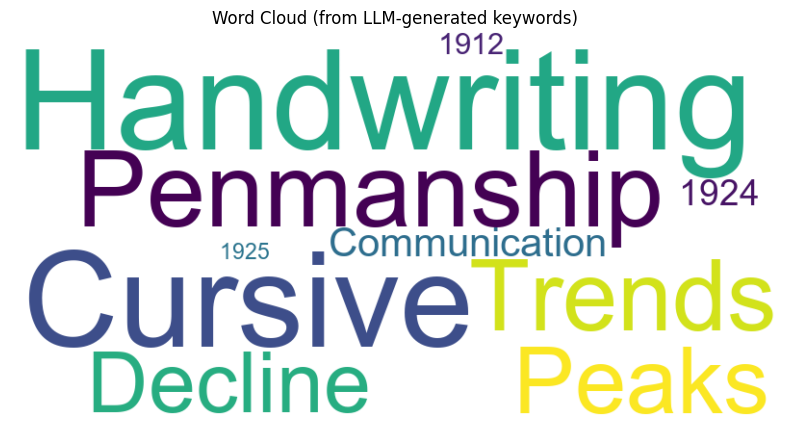

In [131]:
# Save and show
output_file = "wordcloud_handwriting.png"
wc.to_file(output_file)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud (from LLM-generated keywords)")
plt.show()


In [133]:
print(f"Word cloud saved to: {os.path.abspath(output_file)}")

Word cloud saved to: C:\Users\sonal\Downloads\CSI3007 - Advanced Python Programming\wordcloud_handwriting.png
